# RTS Results Comparison Analysis
## Comparing Baseline, NSGA-II, and Random Selection Results

This notebook loads pre-existing results from three approaches and creates comparison plots:
- **Baseline (BCPSO)**: Uses columns `mean_fully_covered_bv` and `mean_fully_covered_req_cov`
- **NSGA-II**: Uses columns `avg_BV` and `avg_req_cvg`
- **Random**: Uses columns `total_business_value` and `req_coverage_pct`

All results are standardized to common column names: `rtw`, `bv`, `req_cov`, and `test_cov`

In [2]:
# ======================================================
# Cell 1: Imports and Setup
# ======================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from io import BytesIO
from openpyxl.drawing.image import Image as OpenpyxlImage
import os
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✓ Imports complete")
print("\nExpected time budget (rtw) values: 5, 10, 15, ..., 100 (19 values total)")

✓ Imports complete

Expected time budget (rtw) values: 5, 10, 15, ..., 100 (19 values total)


In [3]:
# ======================================================
# Cell 2: Mount Google Drive and Set Paths
# ======================================================

from google.colab import drive
drive.mount('/content/drive')

# Set your base path where the result files are located
# Modify this path according to your Google Drive structure
BASE_PATH = '/content/drive/MyDrive/RTS/RTS_Results'  # <-- CHANGE THIS PATH
BASE_PATH_HALF_SIZE = '/content/drive/MyDrive/RTS/Pipeline/RTS Analysis/Half Size Reports'
BASE_PATH_FULL_SIZE = '/content/drive/MyDrive/RTS/Pipeline/RTS Analysis/Full Size Reports'

# Create output directory if it doesn't exist
OUTPUT_PATH = os.path.join(BASE_PATH, 'outputs')
os.makedirs(OUTPUT_PATH, exist_ok=True)

print(f"✓ Google Drive mounted")
print(f"✓ Base path: {BASE_PATH}")
print(f"✓ Output path: {OUTPUT_PATH}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Google Drive mounted
✓ Base path: /content/drive/MyDrive/RTS/RTS_Results
✓ Output path: /content/drive/MyDrive/RTS/RTS_Results/outputs


In [4]:
# ======================================================
# Cell 3: Define File Paths and Column Mappings
# ======================================================

# Define file paths for each approach and dataset
# Modify these paths according to your actual file locations

FILE_PATHS = {
    'half': {
        'baseline': os.path.join(BASE_PATH_HALF_SIZE, '/content/drive/MyDrive/RTS/Pipeline/RTS Analysis/Half Size Reports/BCPSO_Report.xlsx'),  # or .xlsx
        'nsga': os.path.join(BASE_PATH_HALF_SIZE, '/content/drive/MyDrive/RTS/Pipeline/RTS Analysis/Half Size Reports/halfsize_summary.csv'),          # or .xlsx
        'random': os.path.join(BASE_PATH_HALF_SIZE, '/content/drive/MyDrive/RTS/Pipeline/RTS Analysis/Half Size Reports/Random_Selection_Report_defaultJS_halfsize.xlsx')       # or .xlsx
    },
    'full': {
        'baseline': os.path.join(BASE_PATH_FULL_SIZE, '/content/drive/MyDrive/RTS/Pipeline/RTS Analysis/Full Size Reports/BCPSO Results.xlsx'),  # or .xlsx
        'nsga': os.path.join(BASE_PATH_FULL_SIZE, '/content/drive/MyDrive/RTS/Pipeline/RTS Analysis/Full Size Reports/fullsize_summary.csv'),          # or .xlsx
        'random': os.path.join(BASE_PATH_FULL_SIZE, '/content/drive/MyDrive/RTS/Pipeline/RTS Analysis/Full Size Reports/Random_Selection_Report_defaultsize.xlsx')       # or .xlsx
    }
}

# Column mapping rules
COLUMN_MAPPINGS = {
    'baseline': {
        'rtw': 'Time Budget %',
        'bv': 'mean_fully_covered_bv',
        'req_cov': 'mean_fully_covered_req_cov'
    },
    'nsga': {
        'rtw': 'Budget_%',
        'bv': 'avg_BV',
        'req_cov': 'avg_req_cvg',
        'test_cov': 'avg_test_cvg'  # optional
    },
    'random': {
        'rtw': 'budget_pct',  # CHANGED: was 'rtw'
        'bv': 'total_business_value',
        'req_cov': 'req_coverage_pct'
    }
}

# Expected rtw values
EXPECTED_RTW = list(range(5, 96, 5))  # [5, 10, 15, ..., 95]

print("✓ File paths and column mappings defined")
print(f"\nExpected time budget values ({len(EXPECTED_RTW)} total): {EXPECTED_RTW}")

✓ File paths and column mappings defined

Expected time budget values (19 total): [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]


In [5]:
# ======================================================
# Cell 4: Data Loading and Standardization Functions
# ======================================================

def load_results_file(file_path):
    """
    Load results from CSV or Excel file.
    """
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")

    if file_path.endswith('.csv'):
        df = pd.read_csv(file_path)
    elif file_path.endswith(('.xlsx', '.xls')):
        # Try different engines for Excel files
        df = None
        errors = []

        # Try openpyxl first (for .xlsx)
        try:
            df = pd.read_excel(file_path, engine='openpyxl')
        except Exception as e1:
            errors.append(f"openpyxl: {str(e1)}")

            # Try xlrd (for older .xls files)
            try:
                df = pd.read_excel(file_path, engine='xlrd')
            except Exception as e2:
                errors.append(f"xlrd: {str(e2)}")

                # Last resort: try without specifying engine
                try:
                    df = pd.read_excel(file_path)
                except Exception as e3:
                    errors.append(f"default: {str(e3)}")
                    raise ValueError(f"Could not load Excel file {file_path}. Errors: {'; '.join(errors)}")
    else:
        raise ValueError(f"Unsupported file format: {file_path}")

    return df


def validate_columns(df, expected_cols, approach_name, file_path):
    """
    Validate that the dataframe has the expected columns.
    NO fuzzy matching - exact match required.
    """
    df_cols = set(df.columns)
    missing_cols = []

    for std_name, source_col in expected_cols.items():
        if source_col not in df_cols:
            missing_cols.append(source_col)

    if missing_cols:
        error_msg = f"""
ERROR: Column validation failed for {approach_name} approach.
File: {file_path}

Expected columns: {list(expected_cols.values())}
Missing columns: {missing_cols}
Available columns in file: {list(df_cols)}

Please ensure the file has the correct column names.
No fuzzy matching is performed to prevent errors.
        """
        raise ValueError(error_msg)

    print(f"  ✓ Column validation passed for {approach_name}")


def standardize_columns(df, mapping, approach_name):
    """
    Rename columns to standardized names: rtw, bv, req_cov, test_cov.
    """
    # Create reverse mapping (source_col -> standard_name)
    reverse_mapping = {v: k for k, v in mapping.items() if v in df.columns}

    # Rename columns
    df_std = df.rename(columns=reverse_mapping)

    # Add algorithm identifier
    df_std['algorithm'] = approach_name

    # Keep only standardized columns
    std_cols = ['algorithm', 'rtw', 'bv', 'req_cov']
    if 'test_cov' in df_std.columns:
        std_cols.append('test_cov')

    df_std = df_std[std_cols]

    print(f"  ✓ Columns standardized for {approach_name}")
    return df_std


def validate_rtw_values(df, approach_name):
    """
    Validate that rtw values match expected range.
    """
    actual_rtw = sorted(df['rtw'].unique())

    if actual_rtw != EXPECTED_RTW:
        warning_msg = f"""
WARNING: Time budget (rtw) values don't match expected range for {approach_name}.
Expected: {EXPECTED_RTW}
Actual:   {actual_rtw}
        """
        print(warning_msg)
    else:
        print(f"  ✓ RTW values validated for {approach_name}")


def load_and_standardize_approach(file_path, mapping, approach_name):
    """
    Load, validate, and standardize results for one approach.
    """
    print(f"\nLoading {approach_name}...")
    print(f"  File: {file_path}")

    # Load file
    df = load_results_file(file_path)
    print(f"  Loaded {len(df)} rows")

    # Validate columns
    validate_columns(df, mapping, approach_name, file_path)

    # Standardize columns
    df_std = standardize_columns(df, mapping, approach_name)

    # Validate rtw values
    validate_rtw_values(df_std, approach_name)

    print(f"  Final shape: {df_std.shape}")
    return df_std


print("✓ Data loading and standardization functions defined")

✓ Data loading and standardization functions defined


In [6]:
# ======================================================
# Cell 5: Load and Combine Results for One Dataset
# ======================================================

def load_dataset(dataset_type):
    """
    Load and combine all three approaches for a given dataset (half or full).

    Args:
        dataset_type: 'half' or 'full'

    Returns:
        Combined DataFrame with standardized columns
    """
    print(f"\n{'='*80}")
    print(f"LOADING {dataset_type.upper()} DATASET")
    print(f"{'='*80}")

    files = FILE_PATHS[dataset_type]

    # Load each approach
    baseline_df = load_and_standardize_approach(
        files['baseline'],
        COLUMN_MAPPINGS['baseline'],
        'Baseline'
    )

    nsga_df = load_and_standardize_approach(
        files['nsga'],
        COLUMN_MAPPINGS['nsga'],
        'NSGA-II'
    )

    random_df = load_and_standardize_approach(
        files['random'],
        COLUMN_MAPPINGS['random'],
        'Random'
    )

    # Combine all approaches
    combined_df = pd.concat([baseline_df, nsga_df, random_df], ignore_index=True)

    print(f"\n{'='*80}")
    print(f"✓ Combined dataset shape: {combined_df.shape}")
    print(f"✓ Algorithms: {combined_df['algorithm'].unique()}")
    print(f"✓ Time budgets: {sorted(combined_df['rtw'].unique())}")
    print(f"{'='*80}\n")

    return combined_df


print("✓ Dataset loading function defined")
print("\nReady to load data. Run the next cell to load a dataset.")

✓ Dataset loading function defined

Ready to load data. Run the next cell to load a dataset.


In [7]:
# ======================================================
# Cell 6: Load Half Dataset
# ======================================================

try:
    half_dataset_df = load_dataset('half')

    # Display summary
    print("\nSummary Statistics for Half Dataset:")
    print(half_dataset_df.groupby('algorithm')[['bv', 'req_cov']].describe())

    print("\n✓ Half dataset loaded successfully")

except Exception as e:
    print(f"\n❌ Error loading half dataset:")
    print(str(e))
    half_dataset_df = None


LOADING HALF DATASET

Loading Baseline...
  File: /content/drive/MyDrive/RTS/Pipeline/RTS Analysis/Half Size Reports/BCPSO_Report.xlsx
  Loaded 19 rows
  ✓ Column validation passed for Baseline
  ✓ Columns standardized for Baseline
  ✓ RTW values validated for Baseline
  Final shape: (19, 4)

Loading NSGA-II...
  File: /content/drive/MyDrive/RTS/Pipeline/RTS Analysis/Half Size Reports/halfsize_summary.csv
  Loaded 19 rows
  ✓ Column validation passed for NSGA-II
  ✓ Columns standardized for NSGA-II
  ✓ RTW values validated for NSGA-II
  Final shape: (19, 5)

Loading Random...
  File: /content/drive/MyDrive/RTS/Pipeline/RTS Analysis/Half Size Reports/Random_Selection_Report_defaultJS_halfsize.xlsx
  Loaded 570 rows
  ✓ Column validation passed for Random
  ✓ Columns standardized for Random
  ✓ RTW values validated for Random
  Final shape: (570, 4)

✓ Combined dataset shape: (608, 5)
✓ Algorithms: ['Baseline' 'NSGA-II' 'Random']
✓ Time budgets: [np.int64(5), np.int64(10), np.int64(15),

In [8]:
# ======================================================
# Cell 7: Load Full Dataset
# ======================================================

try:
    full_dataset_df = load_dataset('full')

    # Display summary
    print("\nSummary Statistics for Full Dataset:")
    print(full_dataset_df.groupby('algorithm')[['bv', 'req_cov']].describe())

    print("\n✓ Full dataset loaded successfully")

except Exception as e:
    print(f"\n❌ Error loading full dataset:")
    print(str(e))
    full_dataset_df = None


LOADING FULL DATASET

Loading Baseline...
  File: /content/drive/MyDrive/RTS/Pipeline/RTS Analysis/Full Size Reports/BCPSO Results.xlsx
  Loaded 19 rows
  ✓ Column validation passed for Baseline
  ✓ Columns standardized for Baseline
  ✓ RTW values validated for Baseline
  Final shape: (19, 4)

Loading NSGA-II...
  File: /content/drive/MyDrive/RTS/Pipeline/RTS Analysis/Full Size Reports/fullsize_summary.csv
  Loaded 19 rows
  ✓ Column validation passed for NSGA-II
  ✓ Columns standardized for NSGA-II
  ✓ RTW values validated for NSGA-II
  Final shape: (19, 5)

Loading Random...
  File: /content/drive/MyDrive/RTS/Pipeline/RTS Analysis/Full Size Reports/Random_Selection_Report_defaultsize.xlsx
  Loaded 570 rows
  ✓ Column validation passed for Random
  ✓ Columns standardized for Random
  ✓ RTW values validated for Random
  Final shape: (570, 4)

✓ Combined dataset shape: (608, 5)
✓ Algorithms: ['Baseline' 'NSGA-II' 'Random']
✓ Time budgets: [np.int64(5), np.int64(10), np.int64(15), np.in

In [9]:
# ======================================================
# Cell 8: Plotting Functions (Adapted from Original Notebook)
# ======================================================

def create_performance_plots(tidy_df, dataset_name, save_path):
    """
    Create performance plots for the given dataset.
    Adapted from the original notebook's visualization code.
    """
    # Rename columns to match original notebook's expected format
    plot_df = tidy_df.copy()
    plot_df = plot_df.rename(columns={
        'rtw': 'time_budget',
        'bv': 'OP1_BV',
        'req_cov': 'OP2_reqcvg'
    })



    # Define metrics based on available columns
    OUTPUT_METRICS = {
        'OP1_BV': 'Business Value',
        'OP2_reqcvg': 'Requirements Coverage %'
    }


    # Create plots
    print(f"\n--- Generating Performance Plots for {dataset_name} ---")
    fig, axes = plt.subplots(len(OUTPUT_METRICS), 2, figsize=(20, 8 * len(OUTPUT_METRICS)))

    # Handle case where we only have 1 metric (axes won't be 2D)
    if len(OUTPUT_METRICS) == 1:
        axes = axes.reshape(1, -1)

    fig.suptitle(f'Algorithm Performance Analysis - {dataset_name}', fontsize=20, y=1.02)

    for i, (metric_col, metric_name) in enumerate(OUTPUT_METRICS.items()):
        # Individual Box Plots
        sns.boxplot(ax=axes[i, 0], x='time_budget', y=metric_col, hue='algorithm', data=plot_df)
        axes[i, 0].set_title(f'Distribution of {metric_name} vs. Budget')
        axes[i, 0].set_xlabel('RTW')
        axes[i, 0].set_ylabel(metric_name)
        axes[i, 0].tick_params(axis='x', rotation=45)
        axes[i, 0].legend(title='Algorithm')

        # Comparative Line Plots (Mean with SD)
        sns.lineplot(ax=axes[i, 1], x='time_budget', y=metric_col, hue='algorithm',
                    data=plot_df, marker='o', errorbar=None)
        axes[i, 1].set_title(f'Mean {metric_name} vs. Budget (with SD)')
        axes[i, 1].set_xlabel('RTW')
        axes[i, 1].set_ylabel(metric_name)
        axes[i, 1].legend(title='Algorithm')

    plt.tight_layout()

    # Save figure
    plot_filename = os.path.join(save_path, f'performance_plots_{dataset_name.lower().replace(" ", "_")}.png')
    fig.savefig(plot_filename, format='png', bbox_inches='tight', dpi=300)
    print(f"✓ Plots saved to: {plot_filename}")

    plt.show()

    return fig


def create_combined_comparison_plots(half_df, full_df, save_path):
    """
    Create combined comparison plots showing both datasets side by side.
    """
    print(f"\n--- Generating Combined Comparison Plots ---")

    # Add dataset identifier
    half_df_plot = half_df.copy()
    half_df_plot['dataset'] = 'Half'

    full_df_plot = full_df.copy()
    full_df_plot['dataset'] = 'Full'

    # Combine
    combined = pd.concat([half_df_plot, full_df_plot], ignore_index=True)

    # Create figure with subplots for each metric
    metrics = ['bv', 'req_cov']
    metric_names = ['Business Value', 'Requirements Coverage %']

    if 'test_cov' in combined.columns:
        metrics.append('test_cov')
        metric_names.append('Test Coverage (count)')

    fig, axes = plt.subplots(len(metrics), 1, figsize=(16, 6 * len(metrics)))

    if len(metrics) == 1:
        axes = [axes]

    fig.suptitle('Combined Dataset Comparison: Half vs Full', fontsize=20, y=1.02)

    for i, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
        # Create line plot with both dataset and algorithm as hue
        combined['algo_dataset'] = combined['algorithm'] + ' (' + combined['dataset'] + ')'

        sns.lineplot(ax=axes[i], x='rtw', y=metric, hue='algo_dataset',
                    data=combined, marker='o', errorbar= None)
        axes[i].set_title(f'Comparison: {metric_name}')
        axes[i].set_xlabel('RTW')
        axes[i].set_ylabel(metric_name)
        axes[i].legend(title='Algorithm & Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')
        axes[i].grid(True, alpha=0.3)

    plt.tight_layout()

    # Save figure
    plot_filename = os.path.join(save_path, 'combined_comparison_plots.png')
    fig.savefig(plot_filename, format='png', bbox_inches='tight', dpi=300)
    print(f"✓ Combined plots saved to: {plot_filename}")

    plt.show()

    return fig


print("✓ Plotting functions defined")

✓ Plotting functions defined


In [10]:
# ======================================================
# Cell 9: Statistical Analysis Functions
# ======================================================

def generate_statistical_report(tidy_df, dataset_name, save_path):
    """
    Generate comprehensive statistical report in Excel.
    Adapted from the original notebook.
    """
    # Prepare data
    plot_df = tidy_df.copy()
    plot_df = plot_df.rename(columns={
        'rtw': 'time_budget',
        'bv': 'OP1_BV',
        'req_cov': 'OP2_reqcvg'
    })

    if 'test_cov' in plot_df.columns:
        plot_df = plot_df.rename(columns={'test_cov': 'OP3_testcvg'})

    ALGO_NAMES = plot_df['algorithm'].unique().tolist()
    OUTPUT_METRICS = {
        'OP1_BV': 'Business Value',
        'OP2_reqcvg': 'Requirements Coverage %'
    }

    if 'OP3_testcvg' in plot_df.columns:
        OUTPUT_METRICS['OP3_testcvg'] = 'Test Coverage (count)'

    PAIRS_TO_COMPARE = []
    for i, algo1 in enumerate(ALGO_NAMES):
        for algo2 in ALGO_NAMES[i+1:]:
            PAIRS_TO_COMPARE.append((algo1, algo2))

    # Generate Excel report
    output_excel_filename = os.path.join(save_path, f'statistical_analysis_{dataset_name.lower().replace(" ", "_")}.xlsx')
    print(f"\n--- Generating Statistical Report for {dataset_name} ---")
    print(f"Output file: {output_excel_filename}")

    with pd.ExcelWriter(output_excel_filename, engine='openpyxl') as writer:
        # Write raw data
        plot_df.to_excel(writer, sheet_name='Raw_Data', index=False)

        # Statistical tests for each budget and metric
        for budget in sorted(plot_df['time_budget'].unique()):
            for metric_col, metric_name in OUTPUT_METRICS.items():
                if metric_col not in plot_df.columns:
                    continue

                sheet_name = f"{metric_name.replace(' ', '').replace('%', 'pct').replace('(', '').replace(')', '')}_at_{budget}pct"
                sheet_name = sheet_name[:31]  # Excel sheet name limit

                ws = writer.book.create_sheet(title=sheet_name)

                budget_df = plot_df[plot_df['time_budget'] == budget]

                # Descriptive statistics
                stats_summary = budget_df.groupby('algorithm')[metric_col].agg(['mean', 'std', 'min', 'max', 'count'])
                stats_summary = stats_summary.reindex(ALGO_NAMES)
                stats_summary.to_excel(writer, sheet_name=sheet_name, startrow=1, startcol=1)
                ws['B1'] = "Descriptive Statistics"

                # One-way ANOVA
                grouped_data = [budget_df[budget_df['algorithm'] == algo][metric_col].dropna().values
                               for algo in ALGO_NAMES]

                if all(len(d) >= 2 for d in grouped_data):
                    f_stat, p_value = f_oneway(*grouped_data)

                    ws['B10'] = "Overall Comparison (One-way ANOVA)"
                    ws['B11'] = "F-statistic"
                    ws['C11'] = f_stat
                    ws['B12'] = "p-value"
                    ws['C12'] = p_value
                    ws['B13'] = "Result:"
                    ws['C13'] = "Significant difference" if p_value < 0.05 else "No significant difference"

                    # Post-hoc Tukey HSD if significant
                    if p_value < 0.05 and len(ALGO_NAMES) > 2:
                        try:
                            tukey_result = pairwise_tukeyhsd(
                                endog=budget_df[metric_col].dropna(),
                                groups=budget_df['algorithm'].dropna(),
                                alpha=0.05
                            )

                            results_table = pd.DataFrame(
                                data=tukey_result._results_table.data[1:],
                                columns=tukey_result._results_table.data[0]
                            )

                            pairwise_results = []
                            for g1, g2 in PAIRS_TO_COMPARE:
                                res = results_table[
                                    ((results_table['group1']==g1) & (results_table['group2']==g2)) |
                                    ((results_table['group1']==g2) & (results_table['group2']==g1))
                                ]

                                if not res.empty:
                                    res_row = res.iloc[0]
                                    md = res_row['meandiff']
                                    if res_row['group1'] != g1:
                                        md = -md

                                    pairwise_results.append({
                                        'Pair': f"{g1} vs {g2}",
                                        'Mean diff': f"{md:+.4f}",
                                        '95% CI': f"[{res_row['lower']:.4f}, {res_row['upper']:.4f}]",
                                        'p-value': f"{res_row['p-adj']:.4f}",
                                        'Significant?': "Yes" if res_row['reject'] else "No"
                                    })

                            if pairwise_results:
                                tukey_df = pd.DataFrame(pairwise_results)
                                tukey_df.to_excel(writer, sheet_name=sheet_name, startrow=16, startcol=1, index=False)
                                ws['B16'] = "Pairwise Comparisons (Tukey HSD)"

                        except Exception as e:
                            print(f"  Warning: Could not perform Tukey HSD for {sheet_name}: {str(e)}")

    print(f"✓ Statistical report saved to: {output_excel_filename}")
    return output_excel_filename


print("✓ Statistical analysis functions defined")

✓ Statistical analysis functions defined



GENERATING ANALYSIS FOR HALF DATASET

--- Generating Performance Plots for Half Dataset ---
✓ Plots saved to: /content/drive/MyDrive/RTS/RTS_Results/outputs/performance_plots_half_dataset.png


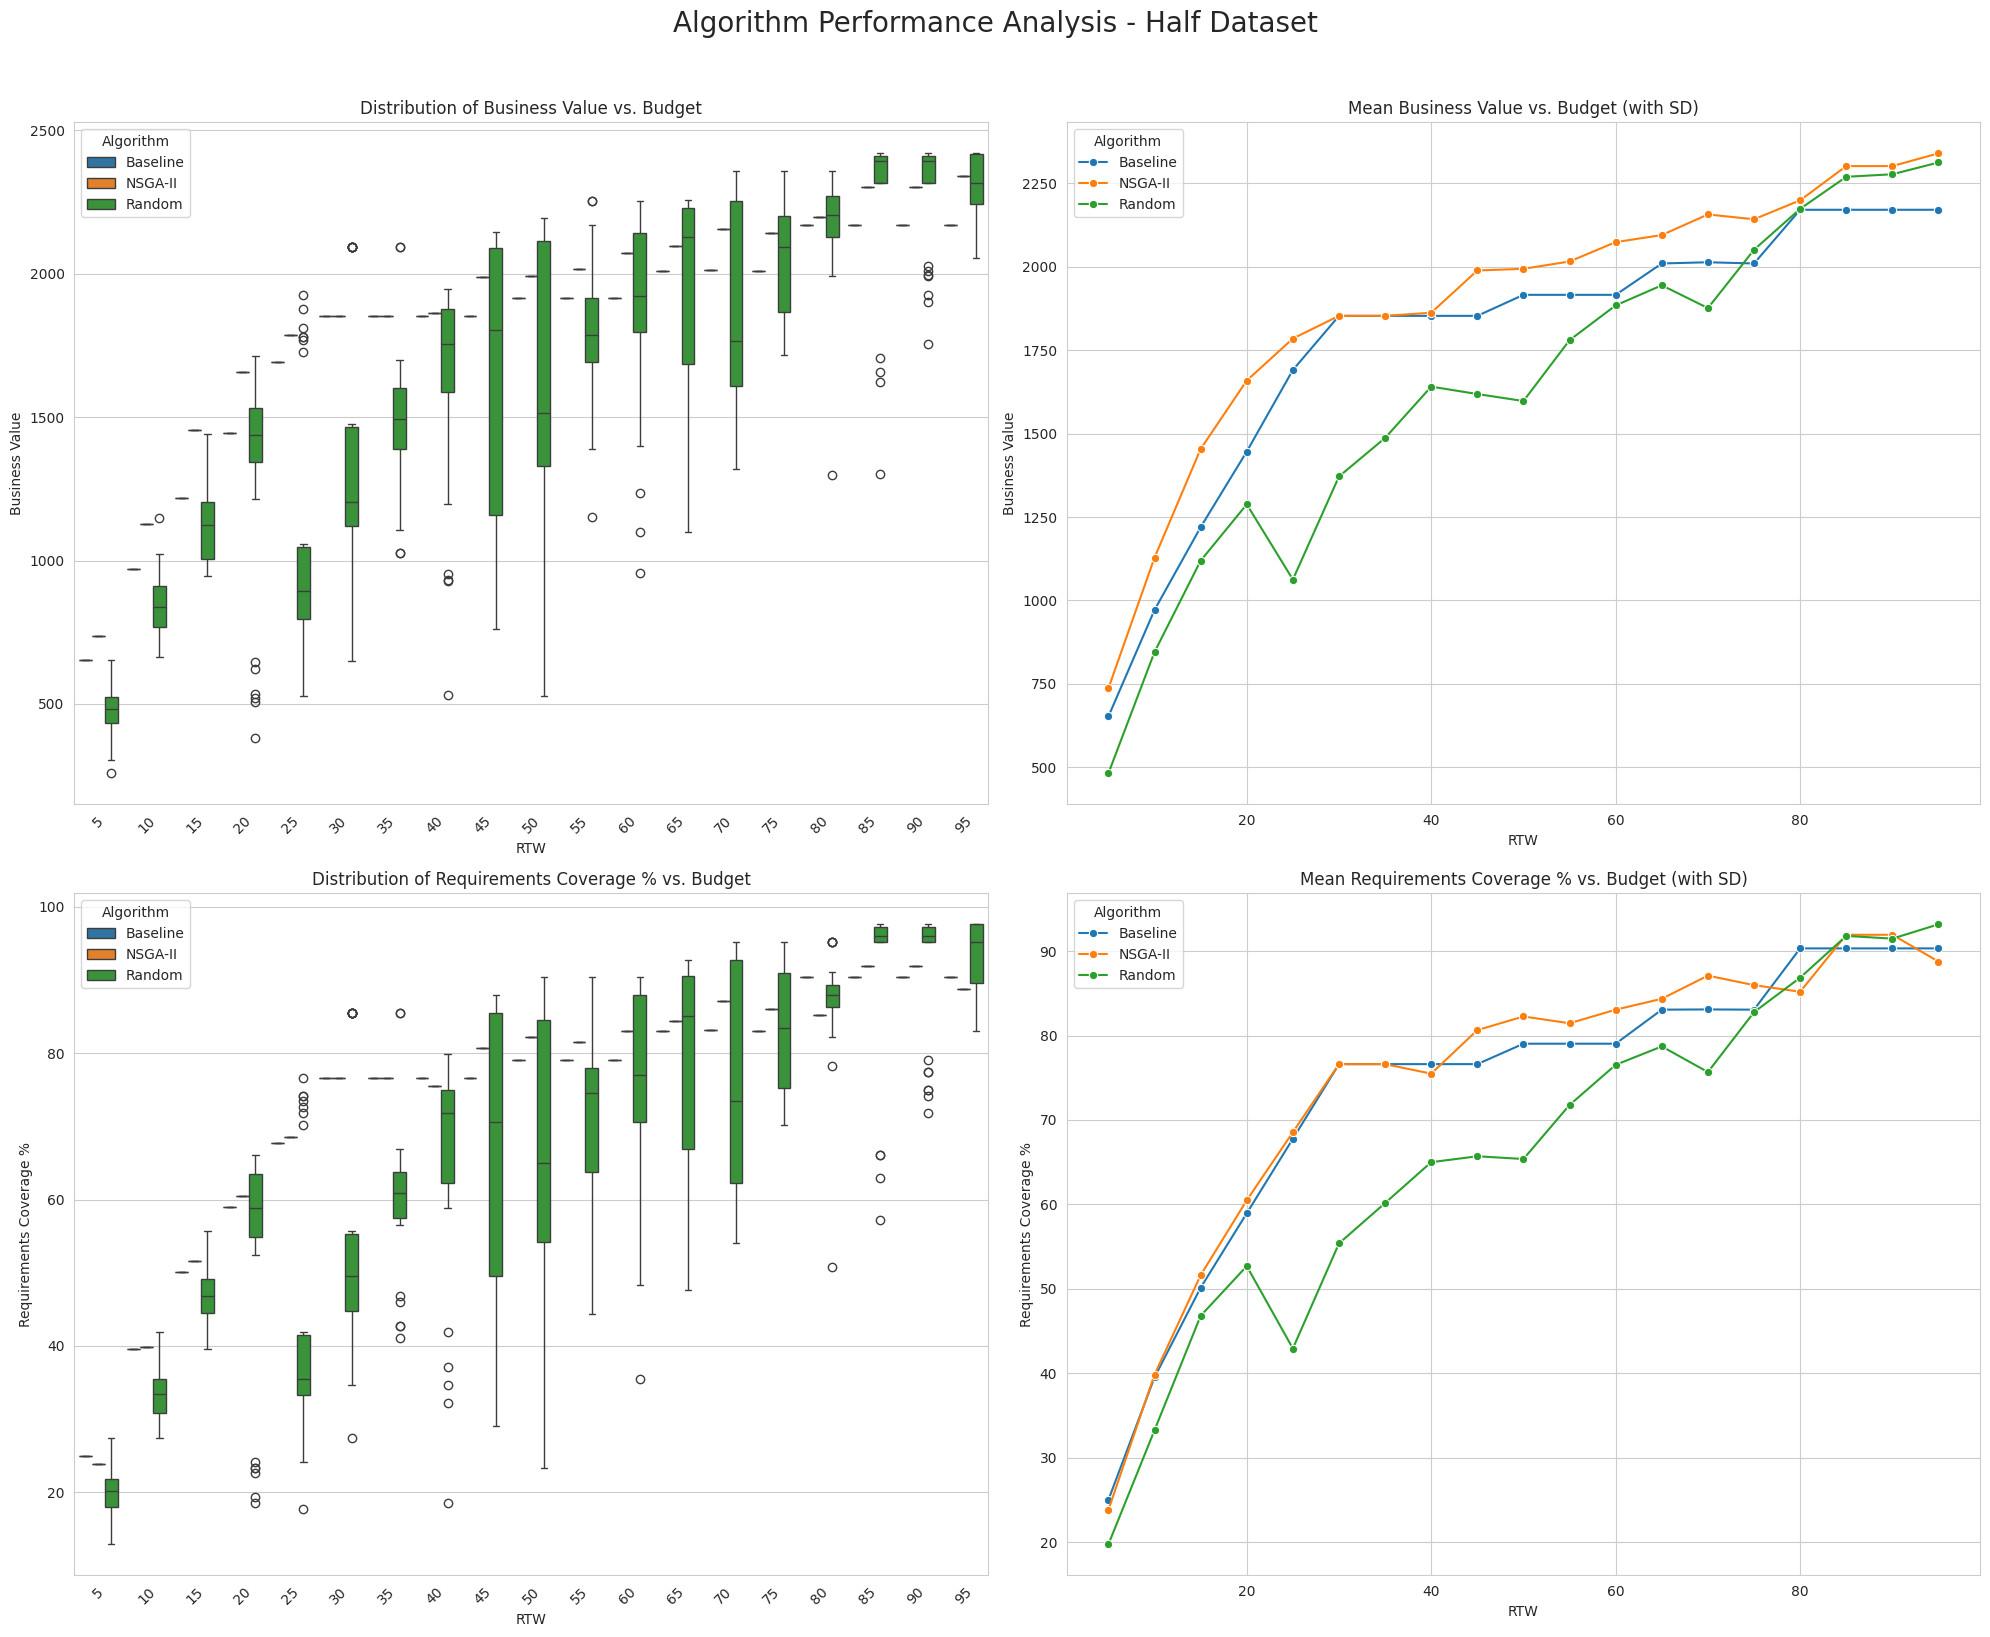


--- Generating Statistical Report for Half Dataset ---
Output file: /content/drive/MyDrive/RTS/RTS_Results/outputs/statistical_analysis_half_dataset.xlsx
✓ Statistical report saved to: /content/drive/MyDrive/RTS/RTS_Results/outputs/statistical_analysis_half_dataset.xlsx

✓ Standardized data saved to: /content/drive/MyDrive/RTS/RTS_Results/outputs/half_dataset_standardized.csv

✓ Half dataset analysis complete


In [11]:
# ======================================================
# Cell 10: Generate Plots and Reports for Half Dataset
# ======================================================

if half_dataset_df is not None:
    print("\n" + "="*80)
    print("GENERATING ANALYSIS FOR HALF DATASET")
    print("="*80)

    # Create performance plots
    half_fig = create_performance_plots(half_dataset_df, "Half Dataset", OUTPUT_PATH)

    # Generate statistical report
    half_report = generate_statistical_report(half_dataset_df, "Half Dataset", OUTPUT_PATH)

    # Save standardized data
    half_data_filename = os.path.join(OUTPUT_PATH, 'half_dataset_standardized.csv')
    half_dataset_df.to_csv(half_data_filename, index=False)
    print(f"\n✓ Standardized data saved to: {half_data_filename}")

    print("\n✓ Half dataset analysis complete")
else:
    print("\n⚠ Half dataset not loaded. Skipping analysis.")


GENERATING ANALYSIS FOR FULL DATASET

--- Generating Performance Plots for Full Dataset ---
✓ Plots saved to: /content/drive/MyDrive/RTS/RTS_Results/outputs/performance_plots_full_dataset.png


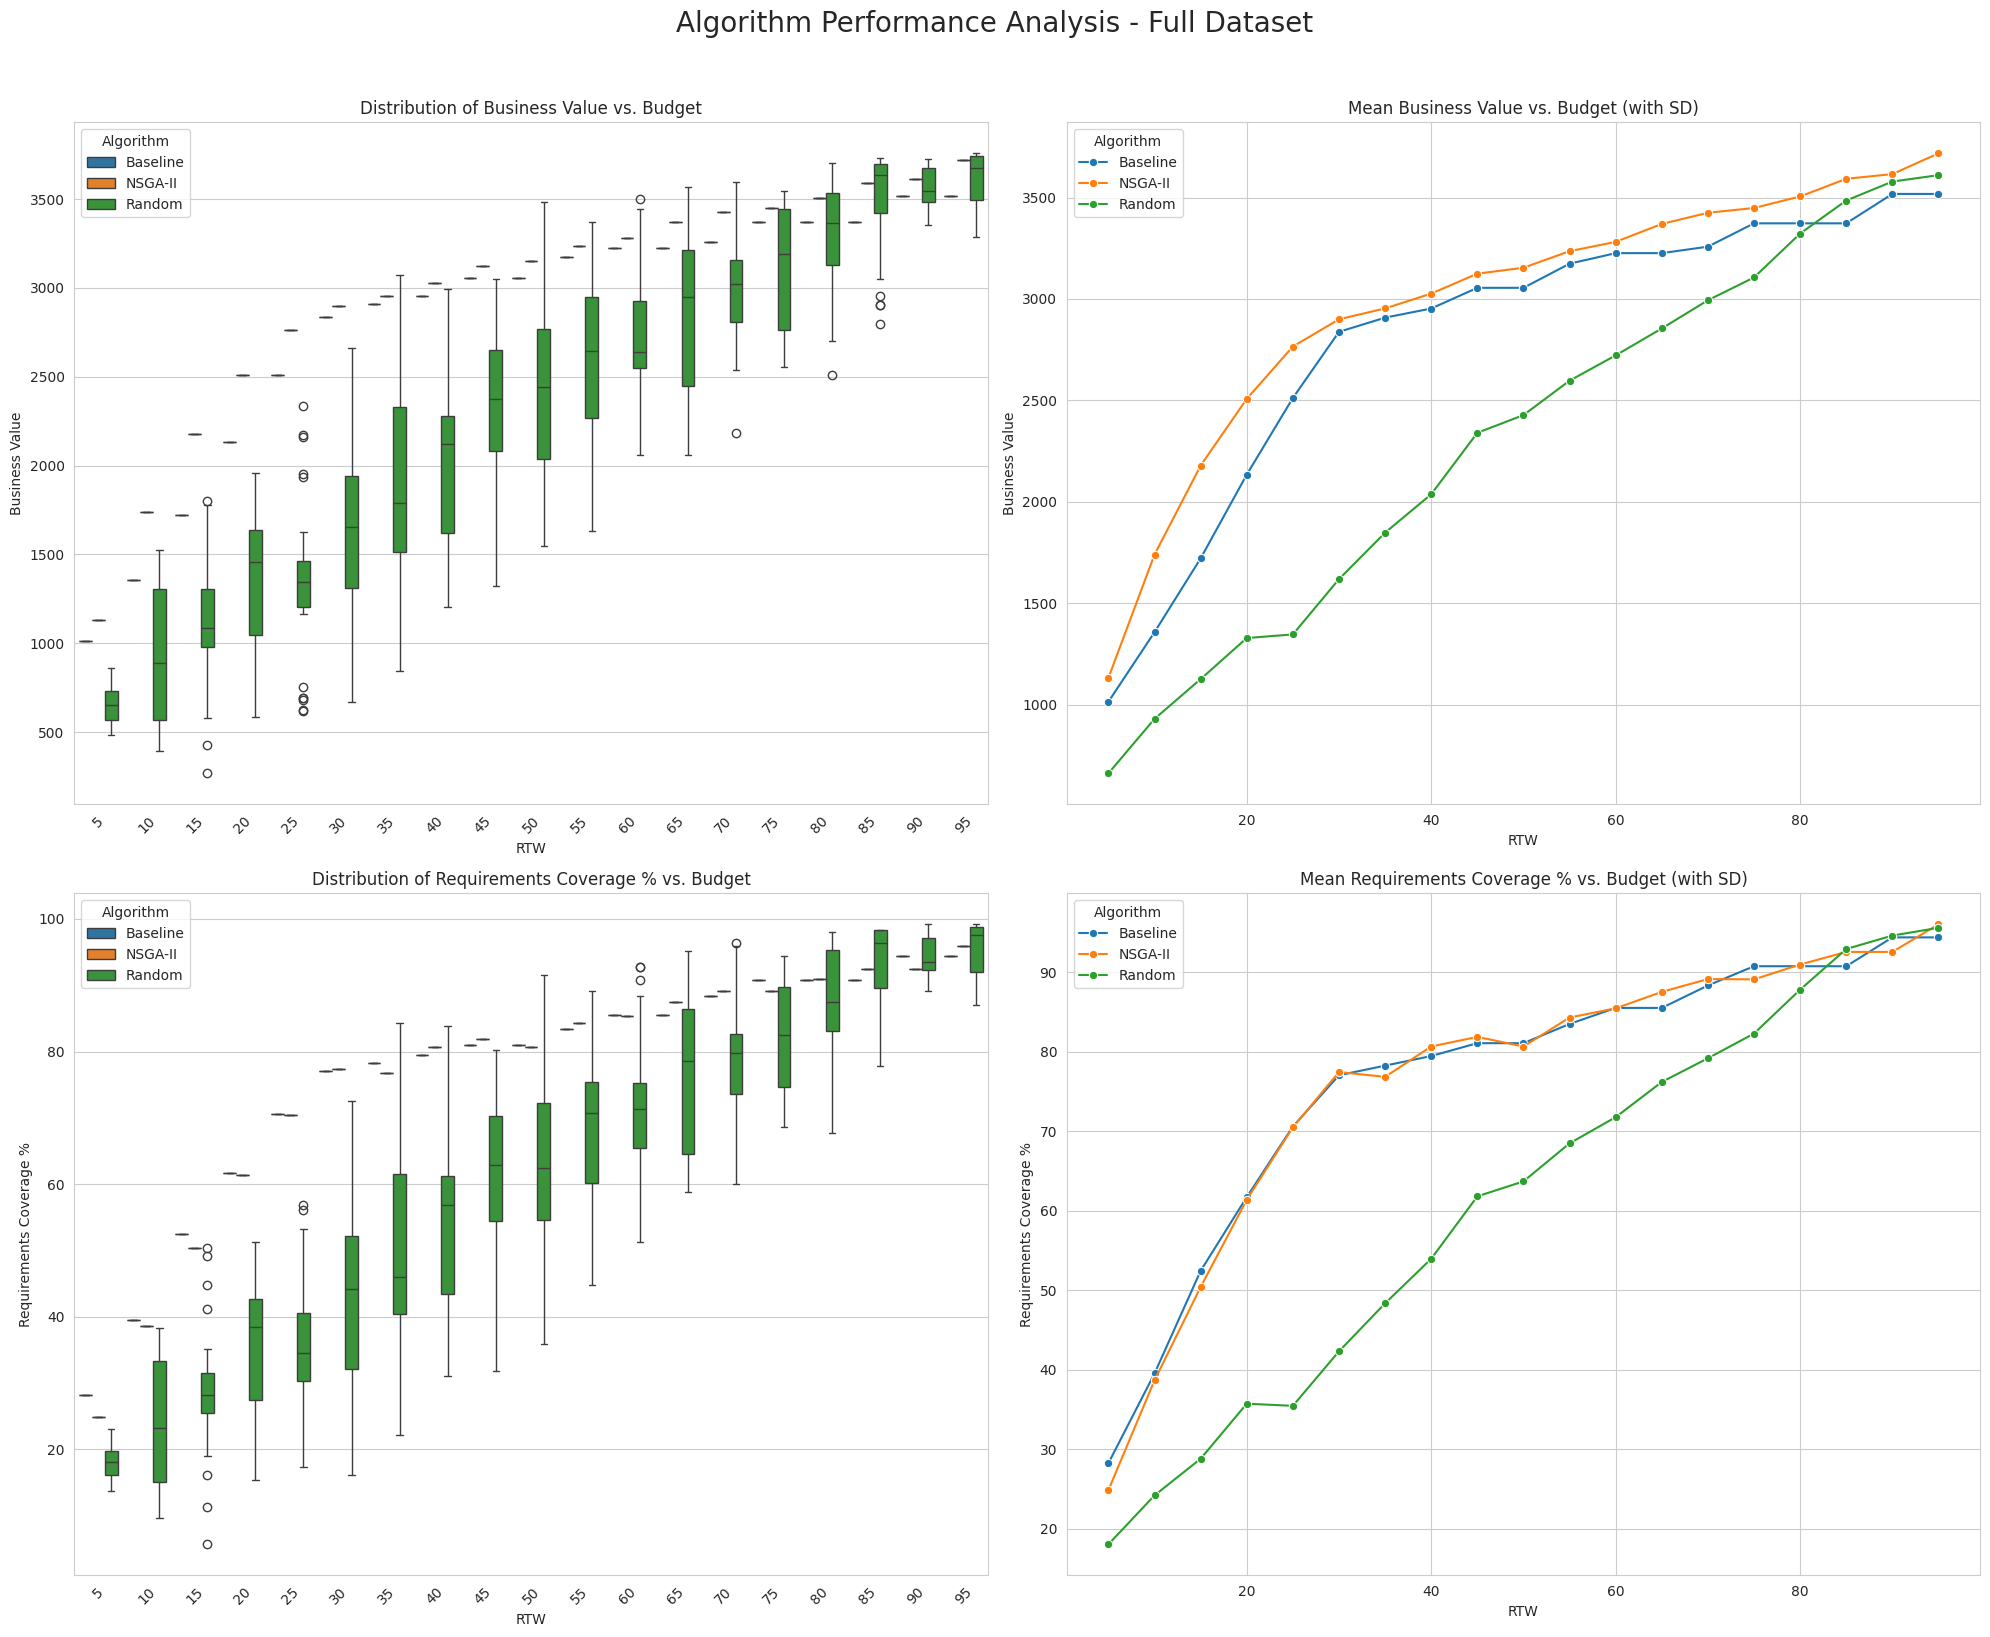


--- Generating Statistical Report for Full Dataset ---
Output file: /content/drive/MyDrive/RTS/RTS_Results/outputs/statistical_analysis_full_dataset.xlsx
✓ Statistical report saved to: /content/drive/MyDrive/RTS/RTS_Results/outputs/statistical_analysis_full_dataset.xlsx

✓ Standardized data saved to: /content/drive/MyDrive/RTS/RTS_Results/outputs/full_dataset_standardized.csv

✓ Full dataset analysis complete


In [12]:
# ======================================================
# Cell 11: Generate Plots and Reports for Full Dataset
# ======================================================

if full_dataset_df is not None:
    print("\n" + "="*80)
    print("GENERATING ANALYSIS FOR FULL DATASET")
    print("="*80)

    # Create performance plots
    full_fig = create_performance_plots(full_dataset_df, "Full Dataset", OUTPUT_PATH)

    # Generate statistical report
    full_report = generate_statistical_report(full_dataset_df, "Full Dataset", OUTPUT_PATH)

    # Save standardized data
    full_data_filename = os.path.join(OUTPUT_PATH, 'full_dataset_standardized.csv')
    full_dataset_df.to_csv(full_data_filename, index=False)
    print(f"\n✓ Standardized data saved to: {full_data_filename}")

    print("\n✓ Full dataset analysis complete")
else:
    print("\n⚠ Full dataset not loaded. Skipping analysis.")


GENERATING COMBINED COMPARISON PLOTS

--- Generating Combined Comparison Plots ---
✓ Combined plots saved to: /content/drive/MyDrive/RTS/RTS_Results/outputs/combined_comparison_plots.png


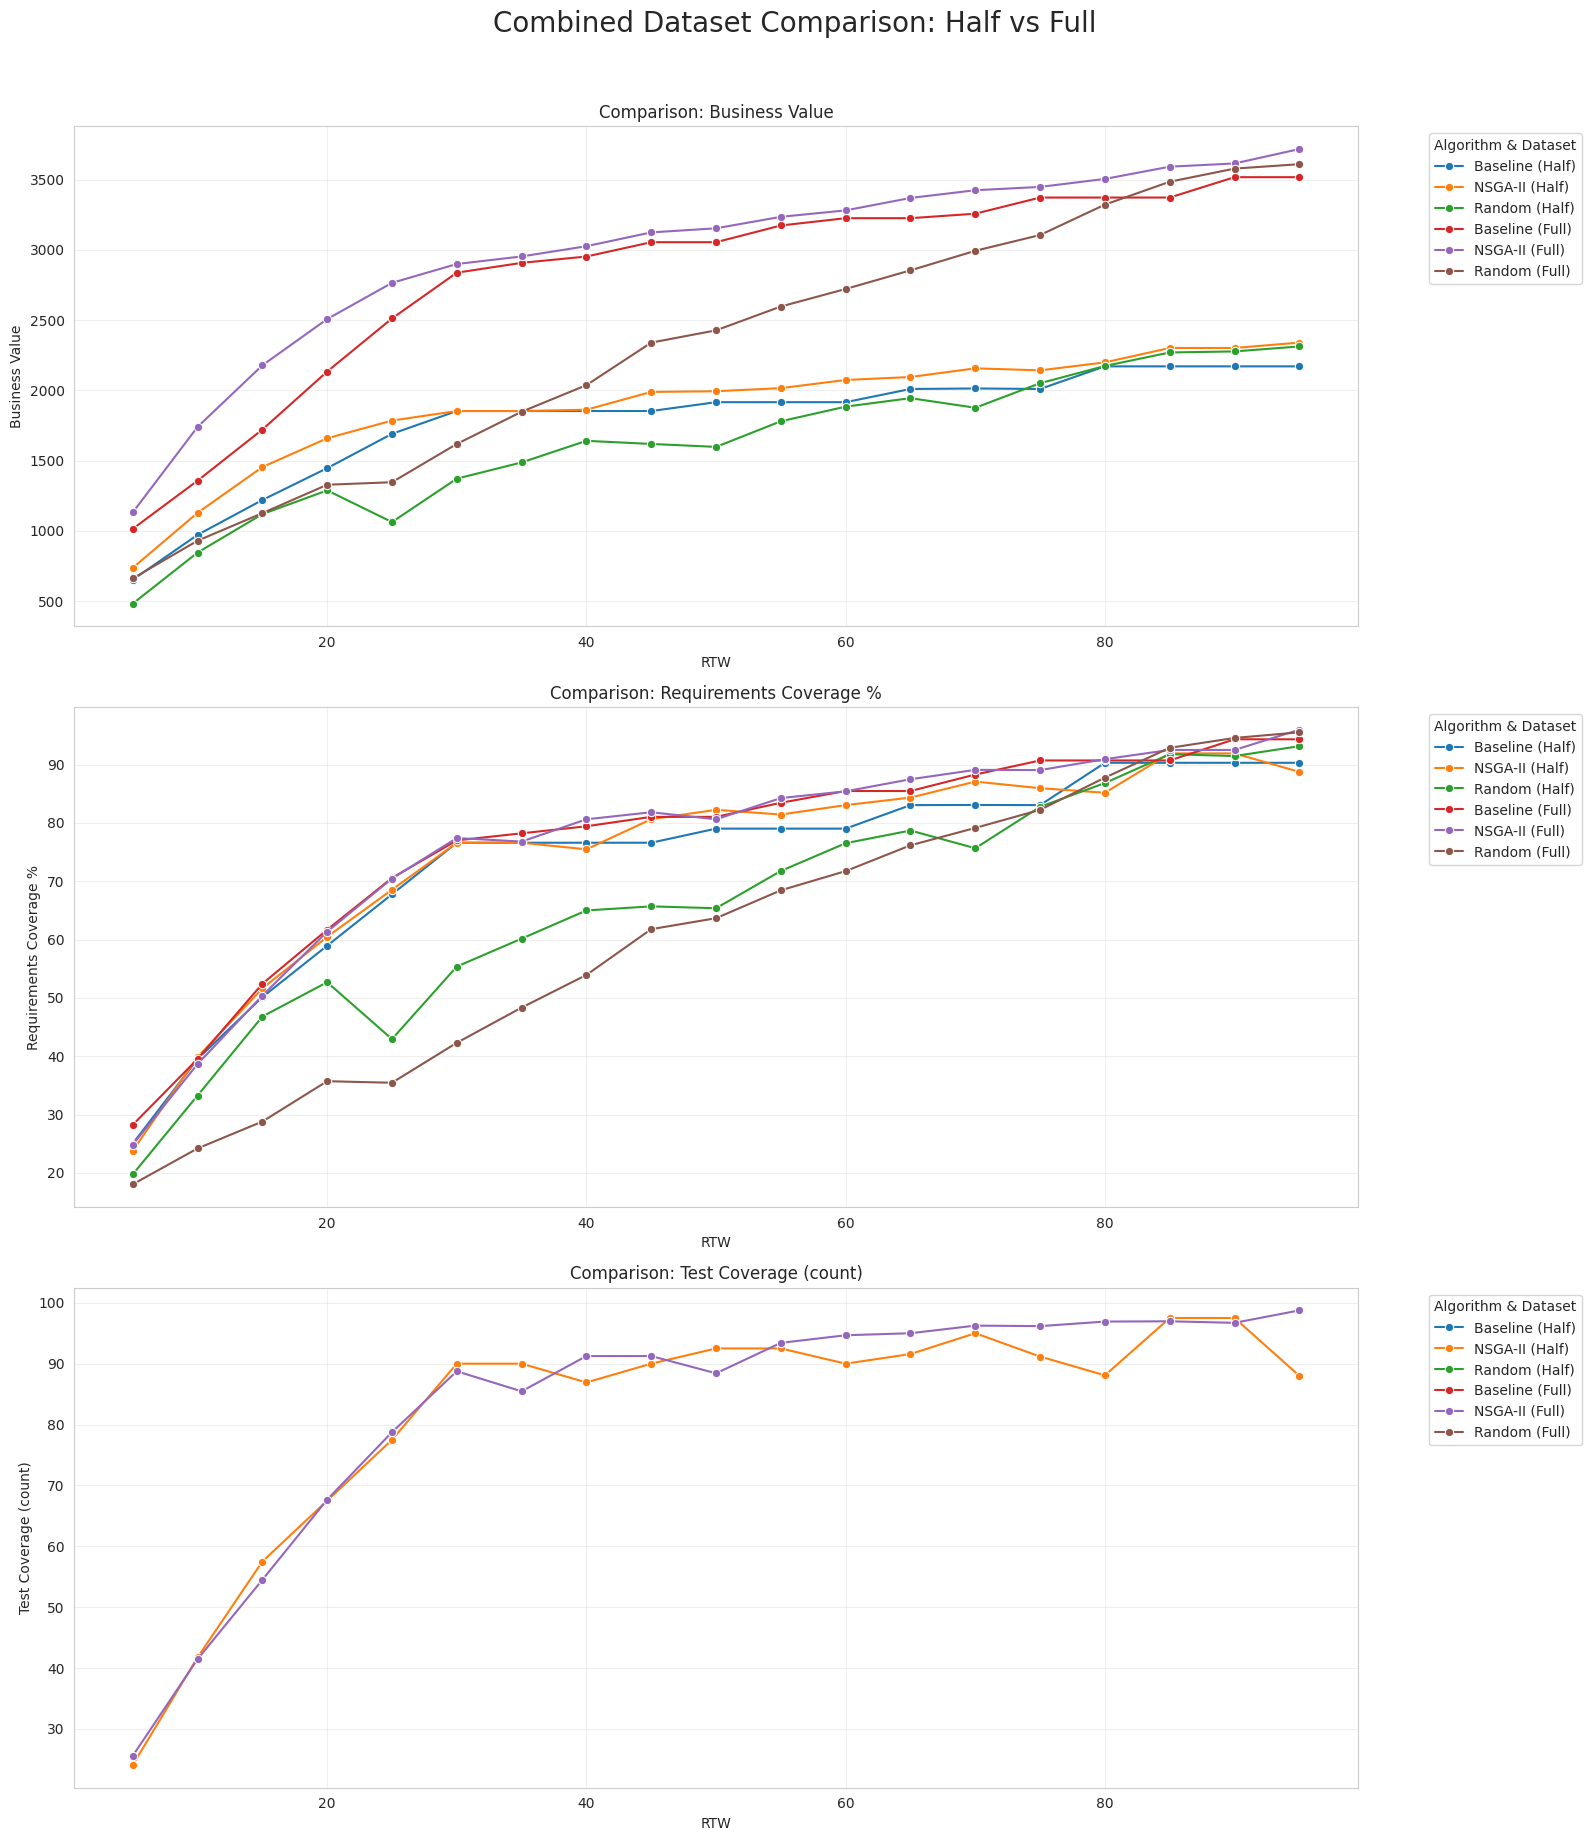


✓ Combined comparison complete


In [13]:
# ======================================================
# Cell 12: Generate Combined Comparison Plots
# ======================================================

if half_dataset_df is not None and full_dataset_df is not None:
    print("\n" + "="*80)
    print("GENERATING COMBINED COMPARISON PLOTS")
    print("="*80)

    # Create combined comparison plots
    combined_fig = create_combined_comparison_plots(half_dataset_df, full_dataset_df, OUTPUT_PATH)

    print("\n✓ Combined comparison complete")
else:
    print("\n⚠ Both datasets required for combined comparison.")
    if half_dataset_df is None:
        print("  Missing: Half dataset")
    if full_dataset_df is None:
        print("  Missing: Full dataset")

In [14]:
# ======================================================
# Cell 13: Summary and Next Steps
# ======================================================

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)

print("\n📁 All outputs saved to:", OUTPUT_PATH)
print("\n📊 Generated files:")

# List all generated files
if os.path.exists(OUTPUT_PATH):
    output_files = sorted(os.listdir(OUTPUT_PATH))
    for i, filename in enumerate(output_files, 1):
        file_path = os.path.join(OUTPUT_PATH, filename)
        file_size = os.path.getsize(file_path) / 1024  # KB
        print(f"  {i}. {filename} ({file_size:.1f} KB)")
else:
    print("  No output files found.")

print("\n" + "="*80)
print("\n✓ Analysis pipeline complete!")
print("\nYou can now:")
print("  1. Review the performance plots (PNG files)")
print("  2. Examine the statistical reports (Excel files)")
print("  3. Use the standardized CSV files for further analysis")


ANALYSIS COMPLETE

📁 All outputs saved to: /content/drive/MyDrive/RTS/RTS_Results/outputs

📊 Generated files:
  1. combined_comparison_plots.png (1073.9 KB)
  2. full_dataset_standardized.csv (21.5 KB)
  3. full_dataset_standardized.gsheet (0.2 KB)
  4. half_dataset_standardized.csv (21.3 KB)
  5. performance_plots_full_dataset.png (828.5 KB)
  6. performance_plots_half_dataset.png (885.1 KB)
  7. statistical_analysis_full_dataset.xlsx (57.4 KB)
  8. statistical_analysis_half_dataset.xlsx (56.6 KB)


✓ Analysis pipeline complete!

You can now:
  1. Review the performance plots (PNG files)
  2. Examine the statistical reports (Excel files)
  3. Use the standardized CSV files for further analysis
